# QWEN IMAGE bitsandbytes | Lowest VRAM configuration <br> (~16GB of VRAM)

In [1]:
import torch
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
from transformers import Qwen2_5_VLForConditionalGeneration
from diffusers import BitsAndBytesConfig as DiffusersBitsAndBytesConfig
from diffusers import QwenImagePipeline, QwenImageTransformer2DModel

## Model Paths

Refer to `download_instructions.txt` for the commands to download the weights where to want rather than <br>
installing them into some overly obscure cache locations where huggingface wants to download everything twice. 

In [2]:
# ensure to adjust paths to you local paths

model_id = "/path/to/Qwen/weights/Qwen-Image"  # <- local path
lora_path = "/path/to/Qwen/Lora/weights/Qwen-Image-Lightning-4steps-V1.0.safetensors"
# lora_path = "/path/to/Qwen/Lora/weights/Qwen-Image-Lightning-8steps-V1.1.safetensors"

## Configuration of Weights

In [3]:
torch_dtype = torch.bfloat16

# nf4 on transformer, skip img_mod to avoid degradation
quant_tf = DiffusersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_skip_modules=["transformer_blocks.0.img_mod"],
)
transformer = QwenImageTransformer2DModel.from_pretrained(
    model_id, subfolder="transformer", quantization_config=quant_tf, torch_dtype=torch_dtype
).to("cpu")

# nf4 on text encoder
quant_te = TransformersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
text_encoder = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, subfolder="text_encoder", quantization_config=quant_te, torch_dtype=torch_dtype
).to("cpu")

# build pipeline
pipe = QwenImagePipeline.from_pretrained(
    model_id, transformer=transformer, text_encoder=text_encoder, torch_dtype=torch_dtype
)
pipe.enable_model_cpu_offload()

The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Configuration of Lora Weights

In [4]:
# load LoRA
pipe.load_lora_weights(lora_path)

## Inference Settings

You can adjust settings in this cell and simply rerun it. 
<br> That'll prevent you from having to reload the weights everytime you want to inference an image.

In [34]:
prompt = (
    "The background: The edge of a cliff where storms thunder and waves massive menacingly tumble. But in the distance "
    "a blue sky tears open before a great light."
    "'ARE YOU EVEN YOU?' "
    "Is written in LIGHT. "
)
negative_prompt = "SYNDICATE_D"
seed = 42 # The meaning of life.
width = 1664
height = 928
steps = 4 
cfg = 1.0

## Inference

In [35]:
gen = torch.Generator(device="cuda").manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    num_inference_steps=steps,      # LoRA 4-step
    true_cfg_scale=cfg,        # LoRA 4-step setting
    generator=gen,
).images[0]


  0%|          | 0/4 [00:00<?, ?it/s]

## Output

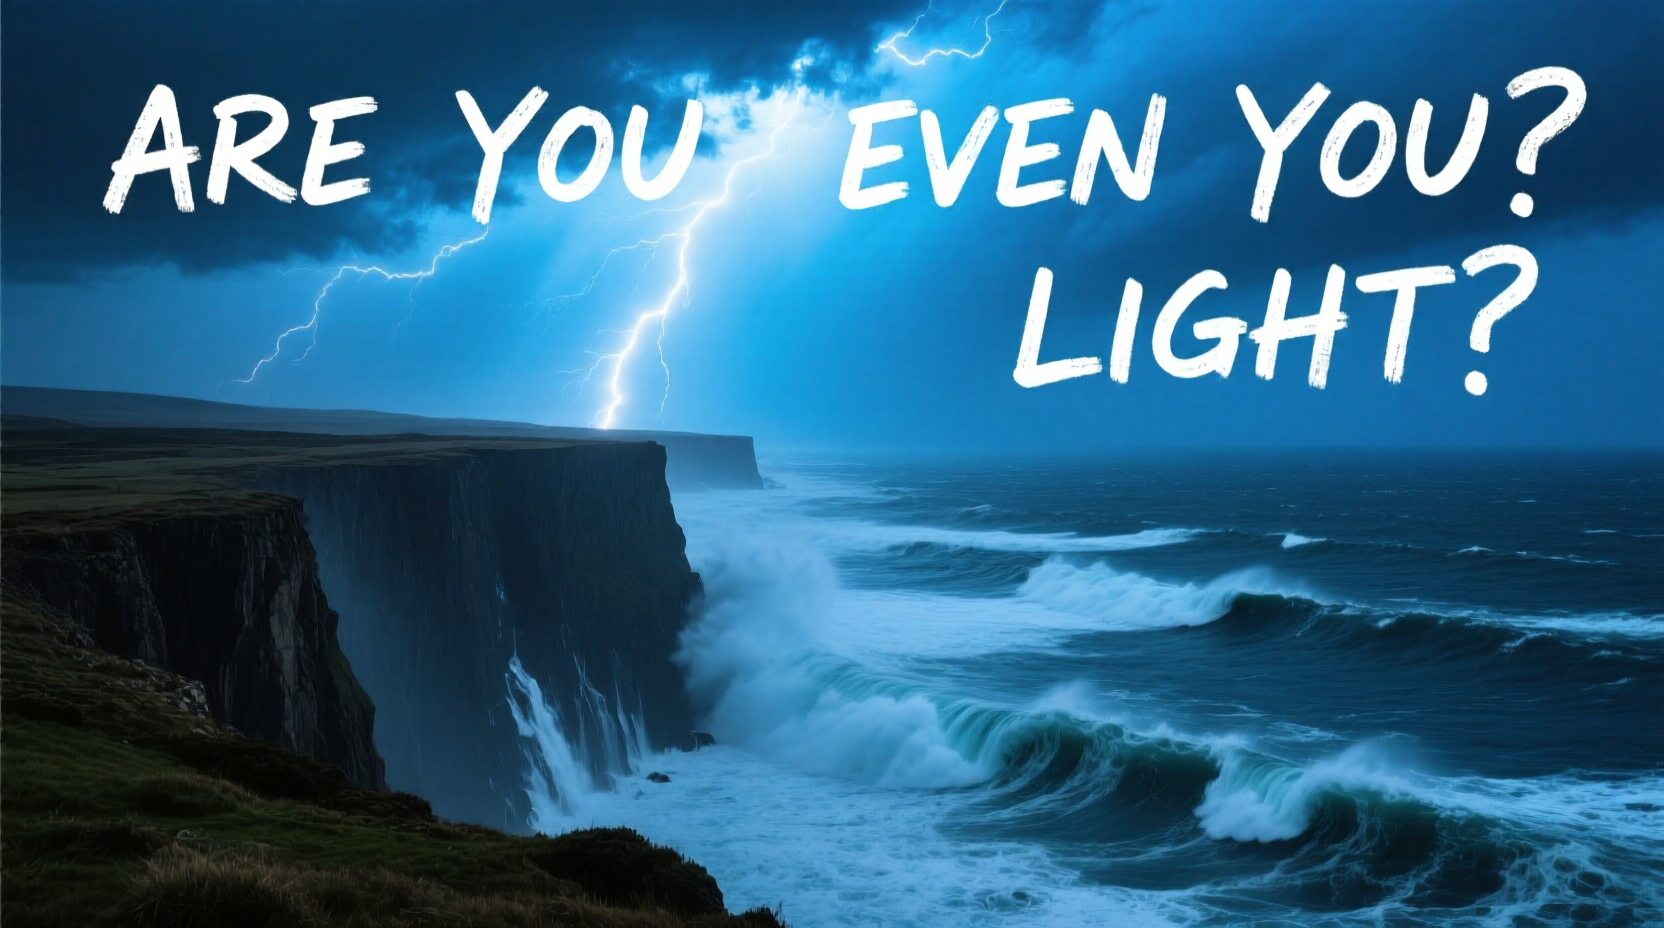

In [36]:
# image.save("qwen_bnb_lora_4step.png")
image